# 0. Reading the Data
I will start with ride ID = 2975587283 which is the first ride of 2020 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 100)

In [2]:
file_paths = {'in':'../../data/enriched/activities/2975587283.csv'
             }

df = pd.read_csv(file_paths['in'])

# guarantee the timestamps are datetime objects
df['time'] = pd.to_datetime(df['time'])

In [3]:
df.head()

,time,ride_id,segment_id,elevation,latitude,longitude,elapsed_time,delta_time,moving_time
0,2020-01-02 14:02:58+00:00,2.975587e+09,0.0,224.30,40.042824,-83.027358,1.0,1.0,1.0
1,2020-01-02 14:02:59+00:00,2.975587e+09,0.0,224.25,40.042851,-83.027424,2.0,1.0,2.0
2,2020-01-02 14:03:00+00:00,2.975587e+09,0.0,224.20,40.042877,-83.027490,3.0,1.0,3.0
3,2020-01-02 14:03:01+00:00,2.975587e+09,0.0,224.20,40.042896,-83.027535,4.0,1.0,4.0
4,2020-01-02 14:03:02+00:00,2.975587e+09,0.0,224.20,40.042914,-83.027581,5.0,1.0,5.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1352 entries, 0 to 1351
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   time          1352 non-null   datetime64[ns, UTC]
 1   ride_id       1352 non-null   float64            
 2   segment_id    1352 non-null   float64            
 3   elevation     1352 non-null   float64            
 4   latitude      1352 non-null   float64            
 5   longitude     1352 non-null   float64            
 6   elapsed_time  1352 non-null   float64            
 7   delta_time    1352 non-null   float64            
 8   moving_time   1352 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(8)
memory usage: 95.2 KB


# 1. Calculating Distance Travelled

In [5]:
from haversine import haversine

def compute_distance(df, latitude='latitude', longitude='longitude', fill_first=0.0):
    df = df.copy()
    # Copy the previous values of Lat/Long to the current row for vectorized computation
    df['lat_old'] = df[latitude].shift()
    df['long_old'] = df[longitude].shift()
    
    # Grab the relevant columns for distance calculation
    df_gps = df[['lat_old', 'long_old', latitude, longitude]]
    
    # Define an anonymous function to execute over each row to calculate the distance between rows
    haversine_distance = lambda x: haversine((x[0], x[1]), (x[2], x[3]), unit='mi')
    
    # Create the distance column, making sure to apply the function row-by-row
    df['delta_dist'] = df_gps.apply(haversine_distance, axis=1)
    df['delta_dist'] = df['delta_dist'].fillna(fill_first)
    
    # Remove the old latitude and longitude columns
    df.drop(['lat_old','long_old'], axis=1, inplace=True)
    return df

In [6]:
df = compute_distance(df)

In [7]:
# compute the cumulative distance elapsed
df['elapsed_distance'] = df['delta_dist'].cumsum()

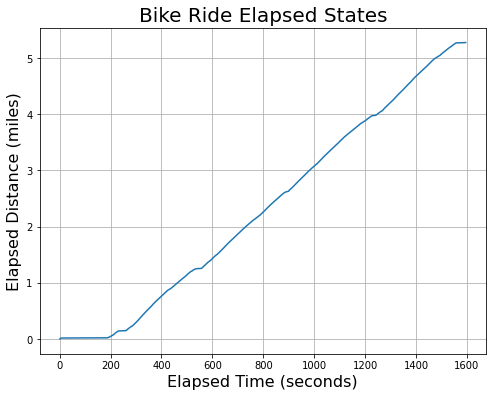

In [8]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(8,6))

_ = plt.plot(df['elapsed_time'], df['elapsed_distance'])
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Elapsed Distance (miles)', fontsize=16)
_ = plt.title('Bike Ride Elapsed States', fontsize=20)
_ = plt.grid()

In [10]:
df.head(2)

,time,ride_id,segment_id,elevation,latitude,longitude,elapsed_time,delta_time,moving_time,delta_dist,elapsed_distance
0,2020-01-02 14:02:58+00:00,2.975587e+09,0.0,224.30,40.042824,-83.027358,1.0,1.0,1.0,0.000000,0.000000
1,2020-01-02 14:02:59+00:00,2.975587e+09,0.0,224.25,40.042851,-83.027424,2.0,1.0,2.0,0.003942,0.003942


In [11]:
df.tail(2)

,time,ride_id,segment_id,elevation,latitude,longitude,elapsed_time,delta_time,moving_time,delta_dist,elapsed_distance
1350,2020-01-02 14:29:31+00:00,2.975587e+09,4.0,223.8,40.042945,-83.027753,1594.0,1.0,1351.0,0.000678,5.275570
1351,2020-01-02 14:29:32+00:00,2.975587e+09,4.0,223.8,40.042954,-83.027747,1595.0,1.0,1352.0,0.000678,5.276248
